<a href="https://colab.research.google.com/github/deepjyotisaha85/eva4/blob/master/session15/S15_Mask_and_Depthmap_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Check GPU

In [2]:
!nvidia-smi

Mon May 25 10:23:00 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

Installations & Imports

In [3]:
!pip install torchviz

     |████████████████████████████████| 51kB 3.5MB/s 
  Created wheel for torchviz: filename=torchviz-0.0.1-cp36-none-any.whl size=3523 sha256=8cb557ad5e719a9f048d5932e76bbc665c77d843fbbbefc1c10569d0c837f481
  Stored in directory: /root/.cache/pip/wheels/2a/c2/c5/b8b4d0f7992c735f6db5bfa3c5f354cf36502037ca2b585667
Successfully built torchviz


In [4]:
!pip install git+https://github.com/arraiyopensource/kornia

import kornia
print(f"Kornia version: {kornia.__version__}")

  Cloning https://github.com/arraiyopensource/kornia to /tmp/pip-req-build-daci9bd4
  Running command git clone -q https://github.com/arraiyopensource/kornia /tmp/pip-req-build-daci9bd4
  Created wheel for kornia: filename=kornia-0.3.2+df93618-py2.py3-none-any.whl size=174640 sha256=9bc1f79117299d20564168df4b6366a92adde2533f0586ecb73a12606c8721c0
  Stored in directory: /tmp/pip-ephem-wheel-cache-8v12p_tc/wheels/a0/47/86/854e2f9a801b368f296cb25f167cbd56aa805f974b15421a67
Successfully built kornia
Kornia version: 0.3.2+df93618


In [0]:
import sys
workingdir = '/content/gdrive/My Drive/Colab Notebooks/EVA4/S15-final'
sys.path.append(workingdir)

In [0]:
import zipfile
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchviz import make_dot
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau
from ipywidgets import HBox, Label, IntProgress
from IPython.display import display
from tqdm import tqdm_notebook as tqdm
from utils import dataprep
from utils import visualize
from utils import training
from utils import dice
from utils import predict
from model import dnn

Unzip & Load the Dataset

In [0]:
archive = zipfile.ZipFile('/content/gdrive/My Drive/EVA4-S15A/image_dataset.zip')
for file in archive.namelist():
        archive.extract(file, '/content/')

In [8]:
!ls '/content/dataset/'

bg  depthmap  fg  fg_mask  image  mask


In [0]:
!ls '/content/dataset/mask' | wc -l

400000


In [9]:
PATH = '/content/dataset/'
mean = (0.50169254, 0.51531572, 0.38720035)
std = (0.25096876, 0.2417532, 0.28520041)
imgdim = 64
datalen = 400000
#datalen = 20000
splitsize = 75
batchsize = 64
numworkers = 4

trainloader, testloader = dataprep.load_data(PATH, datalen, splitsize, mean, std, imgdim, 
                                             batchsize=batchsize, numworkers=numworkers, albumentations=False)

Not Using Albumentations
Train Length:  299999 Test Length:  100000
CUDA Available? True


In [0]:
print("Trainloader: ", len(trainloader))
print("Testloader: ", len(testloader))

Trainloader:  4688
Testloader:  1563


bg: torch.Size([64, 3, 64, 64])


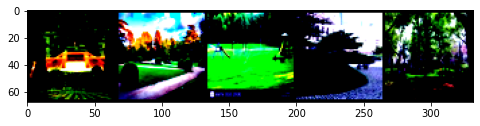

image: torch.Size([64, 3, 64, 64])


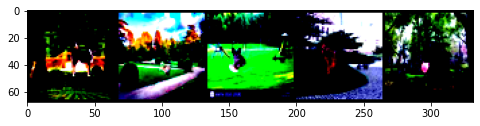

mask: torch.Size([64, 1, 64, 64])


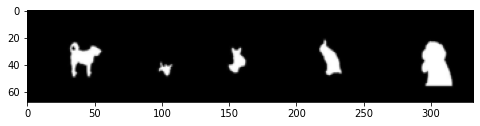

depthmap: torch.Size([64, 1, 64, 64])


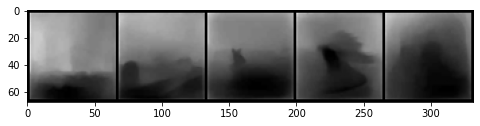

In [0]:
visualize.show_random_images(trainloader, 8)

bg: torch.Size([64, 3, 64, 64])


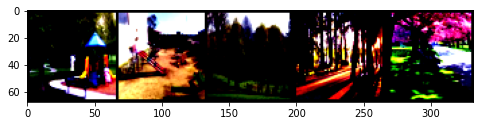

image: torch.Size([64, 3, 64, 64])


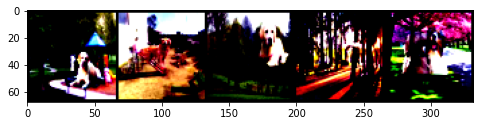

mask: torch.Size([64, 1, 64, 64])


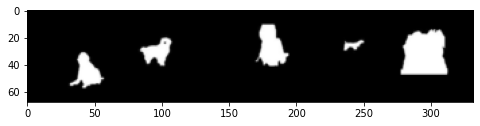

depthmap: torch.Size([64, 1, 64, 64])


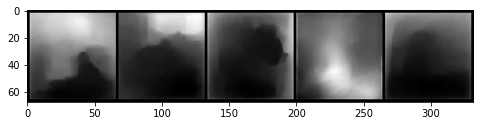

In [0]:
visualize.show_random_images(testloader, 8)

Intantiate the model, loss functions etc.

In [10]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
inchannels = 3
net = dnn.CustomNet15(inchannels)
model = net.to(device)
summary(model, input_size=[(inchannels, imgdim, imgdim), (inchannels, imgdim, imgdim)])

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             864
       BatchNorm2d-2           [-1, 32, 64, 64]              64
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 32, 64, 64]             864
       BatchNorm2d-5           [-1, 32, 64, 64]              64
              ReLU-6           [-1, 32, 64, 64]               0
            Conv2d-7           [-1, 64, 64, 64]          18,432
       BatchNorm2d-8           [-1, 64, 64, 64]             128
              ReLU-9           [-1, 64, 64, 64]               0
           Conv2d-10           [-1, 64, 64, 64]          36,864
      BatchNorm2d-11           [-1, 64, 64, 64]             128
             ReLU-12           [-1, 64, 64, 64]               0
           Conv2d-13           [-1, 64, 64, 64]          36,864
      BatchNorm2d-14           [-1

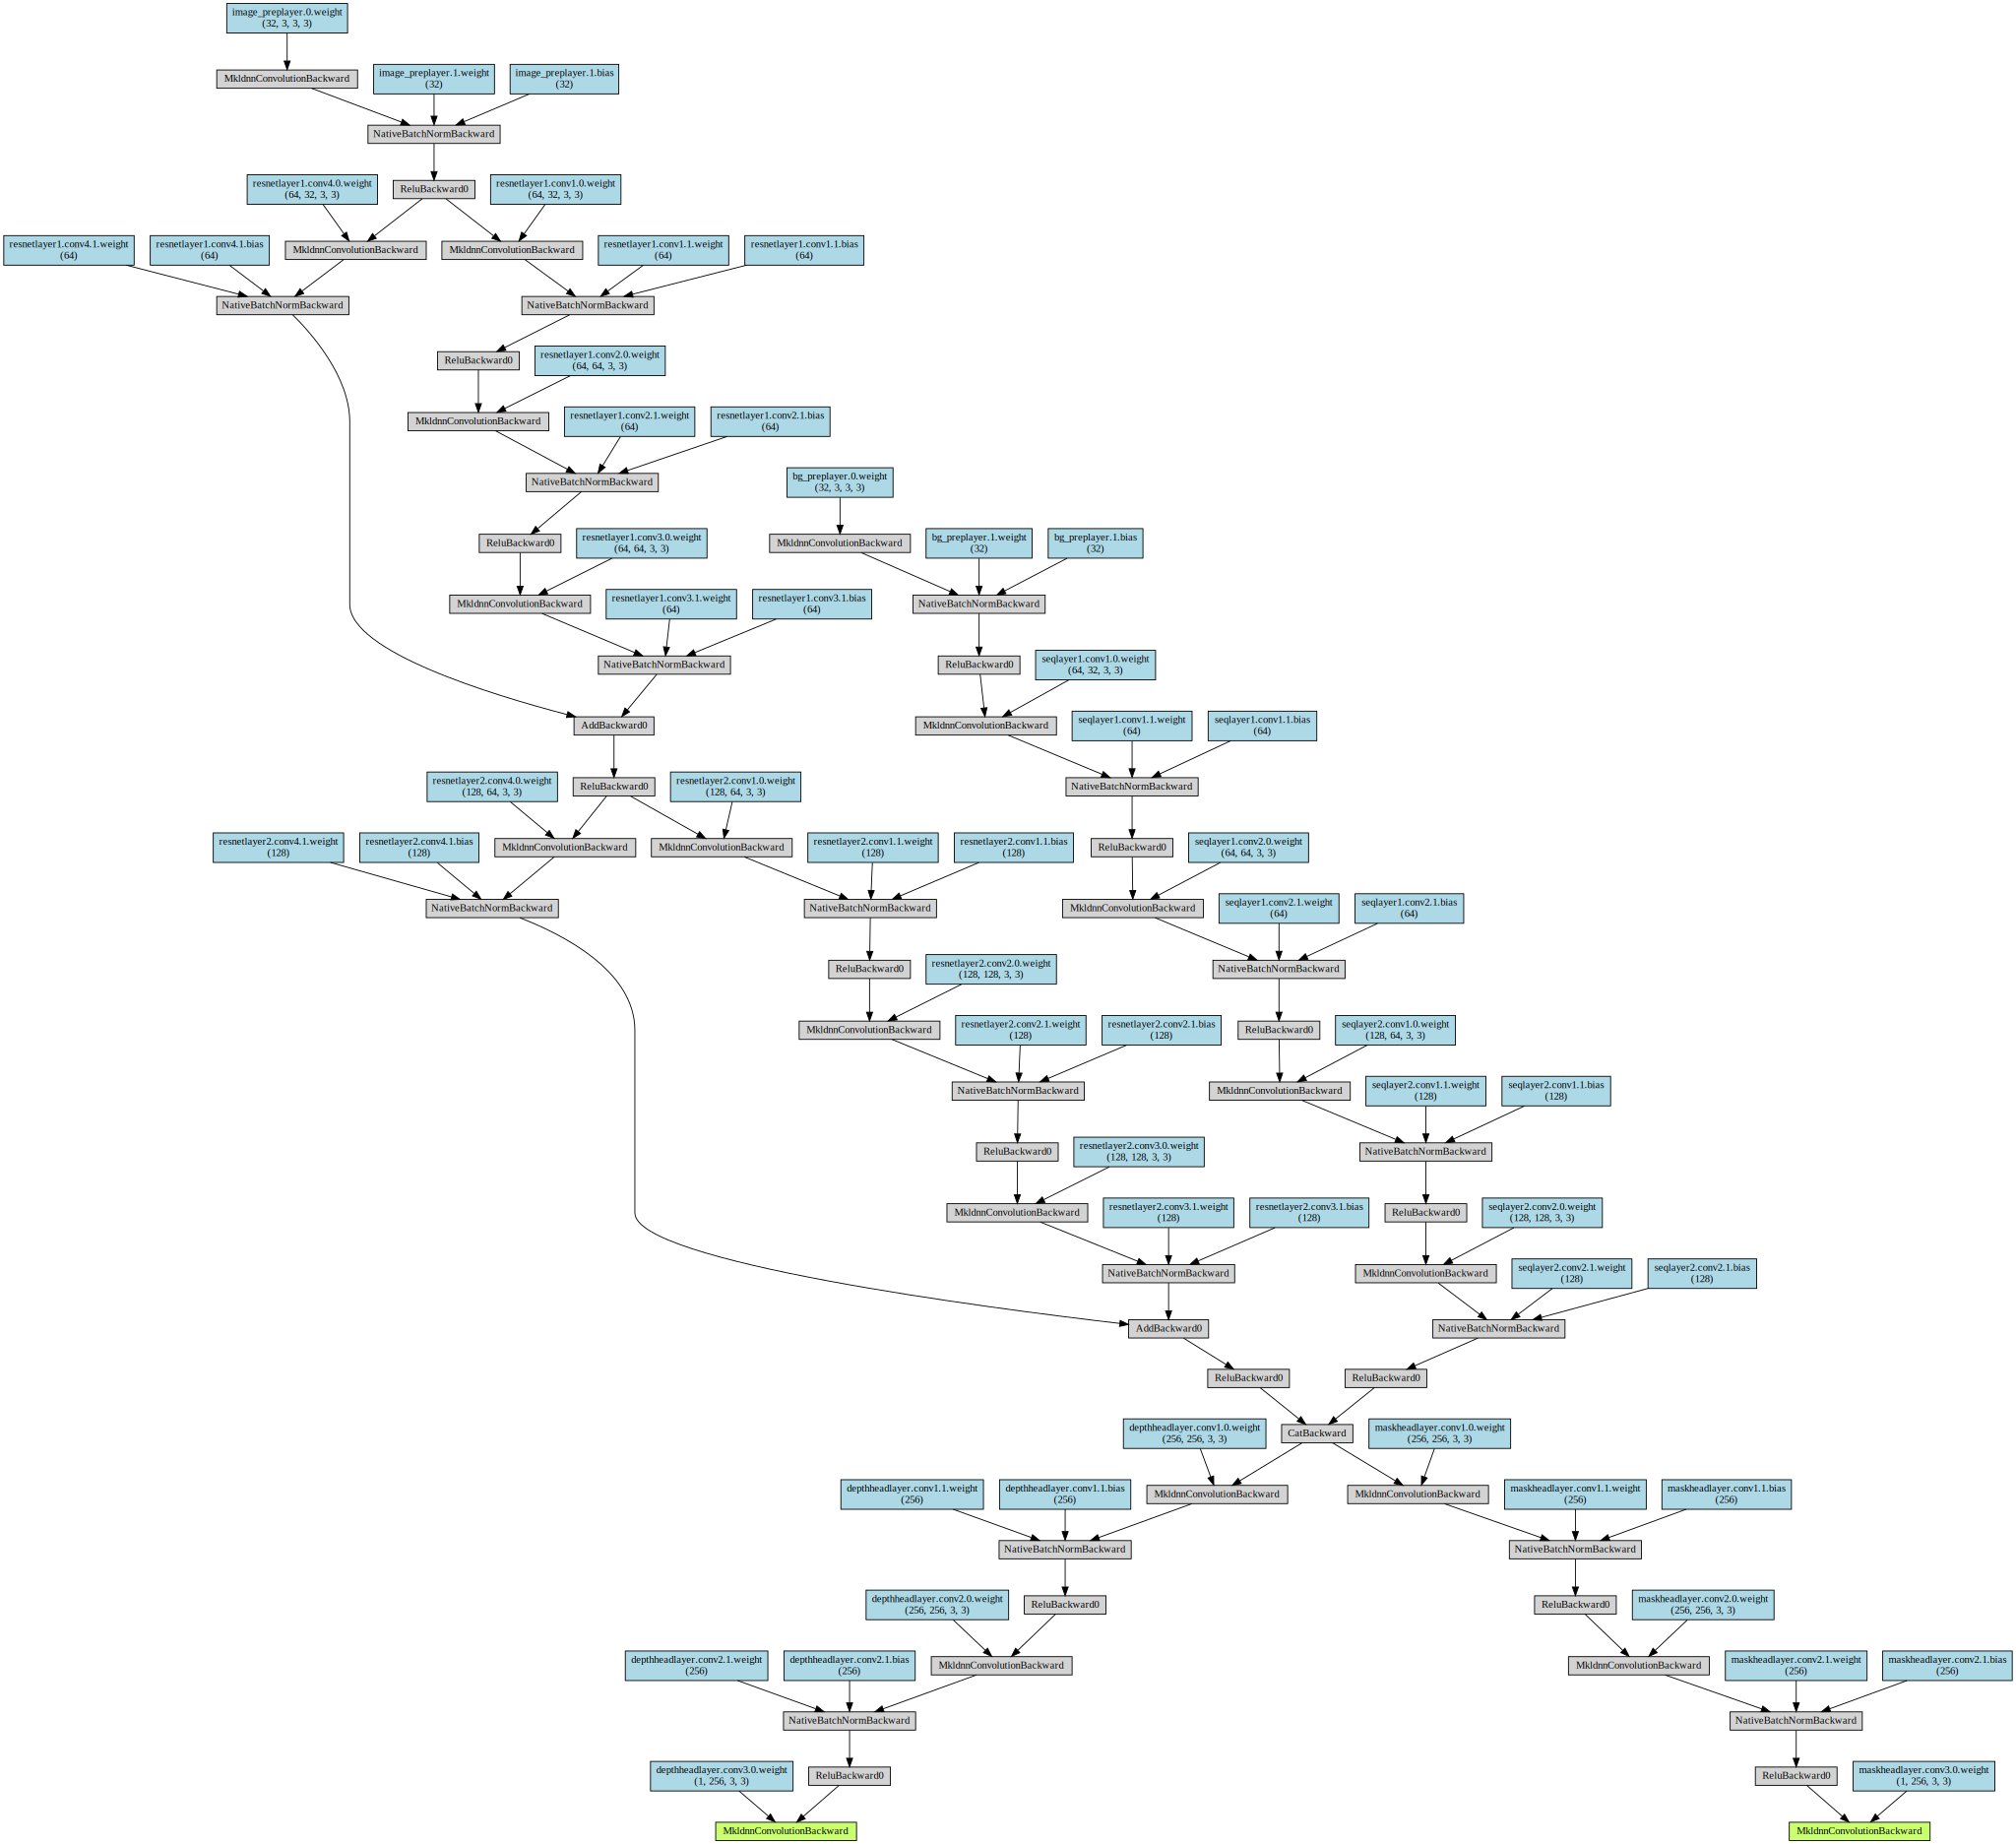

In [0]:
inputdata = torch.zeros(1, inchannels, imgdim, imgdim, dtype=torch.float, requires_grad=False)
make_dot(model.cpu()(inputdata, inputdata), params=dict(model.named_parameters()))

In [0]:
make_dot(model.cpu()(inputdata, inputdata), params=dict(model.named_parameters())).render("custom_model", format="png")

'custom_model.png'

In [0]:
!cp '/content/custom_model.png' '/content/gdrive/My Drive/Colab Notebooks/EVA4/S15-final/'

In [0]:
lr = 0.001
# BCELogitsLoss for Mask & Custom Loss for Depthmap
criterion_mask = nn.BCEWithLogitsLoss()
criterion_depth = kornia.losses.SSIM(5, reduction='mean')
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=3,verbose=True, min_lr=1e-5)

In [0]:
LOADMODEL = True

MODELLOAD = '/content/gdrive/My Drive/Colab Notebooks/EVA4/S15-final/trainedmodels/trained_model_23.pth'

if LOADMODEL:
  checkpoint = torch.load(MODELLOAD)
  model.load_state_dict(checkpoint['state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer'])
  epoch = checkpoint['epoch']

Label(value='Starting Training the Model Now...')

EPOCH: 1 LR: 0.001



*********************** TEST ***********************
Mask Dice Coeff:  0.8653132216867848 Depthmap Dice Coeff:  0.35750622359972617
======================= IMAGE ======================
image: torch.Size([32, 3, 64, 64])


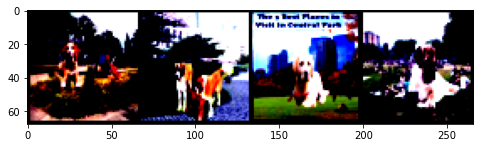

======================= MASK =======================
actual: torch.Size([32, 1, 64, 64])


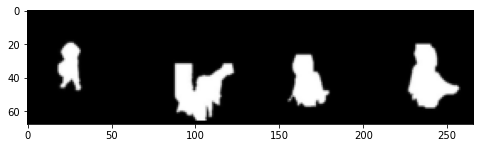

predicted: torch.Size([32, 1, 64, 64])


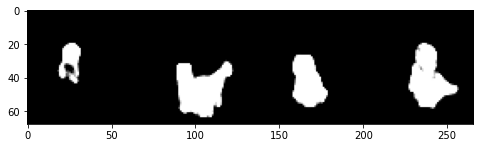

======================= DEPTHMAP ===================
actual: torch.Size([32, 1, 64, 64])


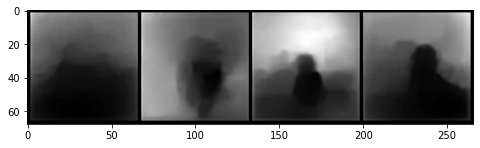

predicted: torch.Size([32, 1, 64, 64])


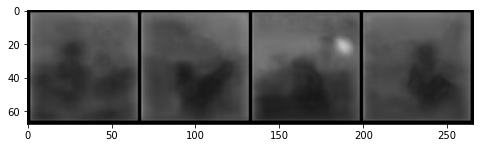

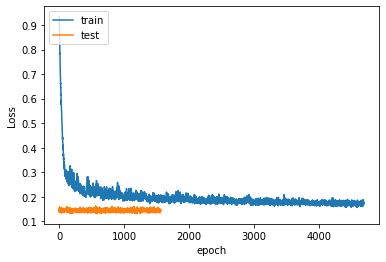

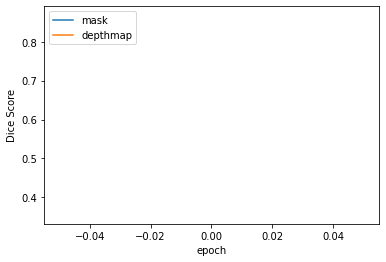

EPOCH: 2 LR: 0.001



*********************** TEST ***********************
Mask Dice Coeff:  0.8810495492058996 Depthmap Dice Coeff:  0.36191973099705504
======================= IMAGE ======================
image: torch.Size([32, 3, 64, 64])


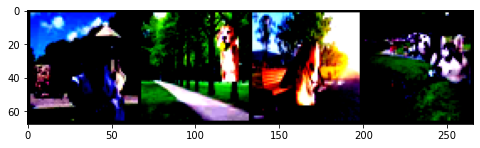

======================= MASK =======================
actual: torch.Size([32, 1, 64, 64])


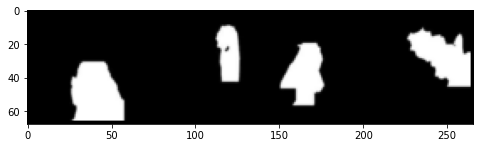

predicted: torch.Size([32, 1, 64, 64])


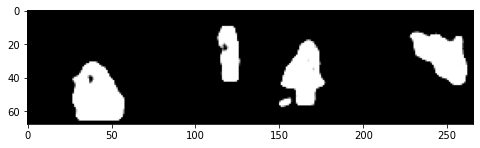

======================= DEPTHMAP ===================
actual: torch.Size([32, 1, 64, 64])


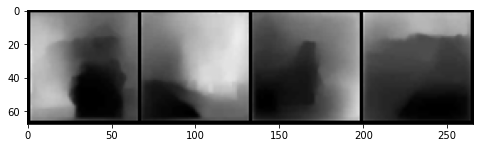

predicted: torch.Size([32, 1, 64, 64])


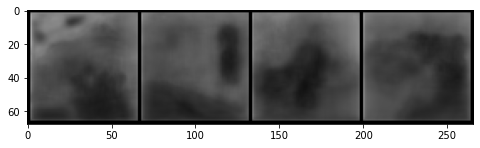

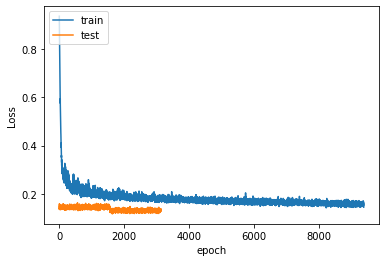

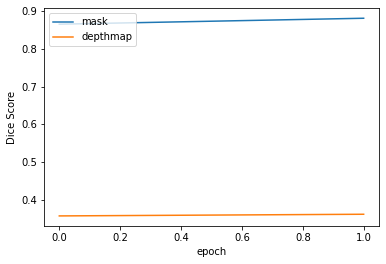

EPOCH: 3 LR: 0.001



*********************** TEST ***********************
Mask Dice Coeff:  0.8894830879231561 Depthmap Dice Coeff:  0.36480844442232707
======================= IMAGE ======================
image: torch.Size([32, 3, 64, 64])


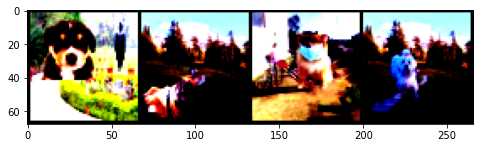

======================= MASK =======================
actual: torch.Size([32, 1, 64, 64])


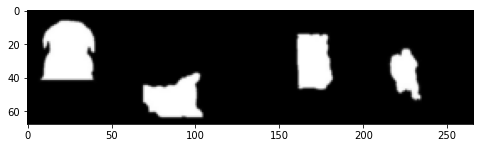

predicted: torch.Size([32, 1, 64, 64])


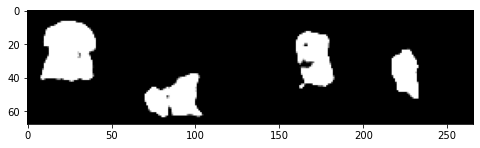

======================= DEPTHMAP ===================
actual: torch.Size([32, 1, 64, 64])


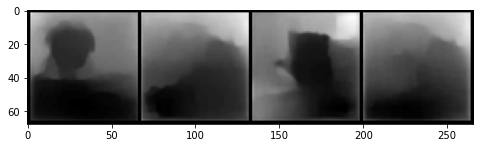

predicted: torch.Size([32, 1, 64, 64])


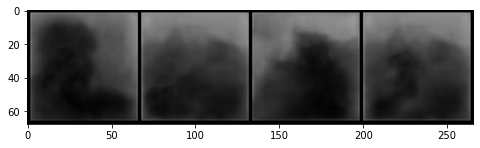

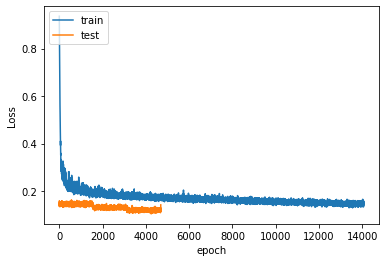

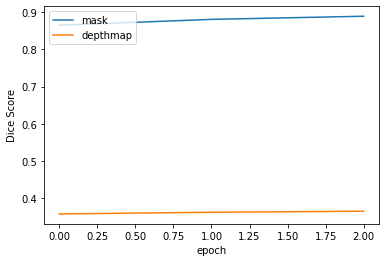

EPOCH: 4 LR: 0.001



*********************** TEST ***********************
Mask Dice Coeff:  0.8923729236737628 Depthmap Dice Coeff:  0.39014340827500144
======================= IMAGE ======================
image: torch.Size([32, 3, 64, 64])


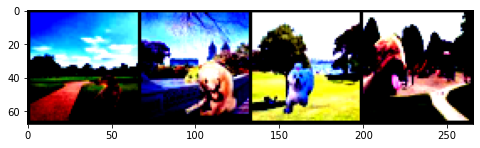

======================= MASK =======================
actual: torch.Size([32, 1, 64, 64])


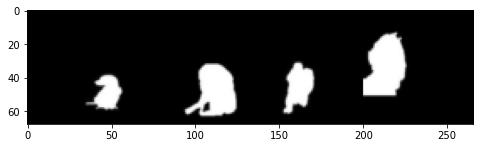

predicted: torch.Size([32, 1, 64, 64])


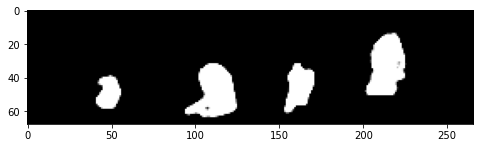

======================= DEPTHMAP ===================
actual: torch.Size([32, 1, 64, 64])


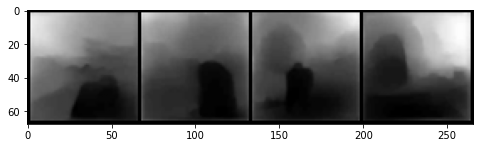

predicted: torch.Size([32, 1, 64, 64])


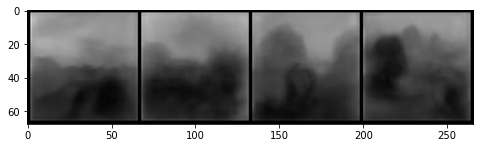

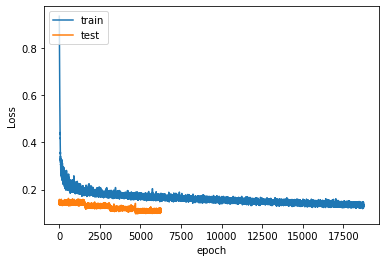

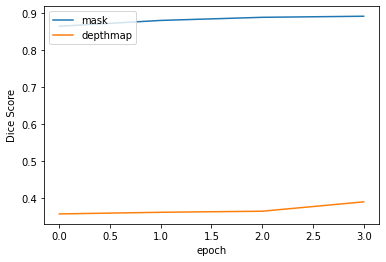

EPOCH: 5 LR: 0.001



*********************** TEST ***********************
Mask Dice Coeff:  0.8953306703939701 Depthmap Dice Coeff:  0.3979617345050902
======================= IMAGE ======================
image: torch.Size([32, 3, 64, 64])


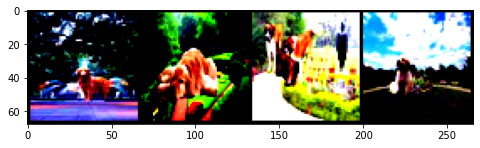

======================= MASK =======================
actual: torch.Size([32, 1, 64, 64])


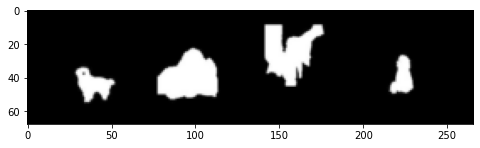

predicted: torch.Size([32, 1, 64, 64])


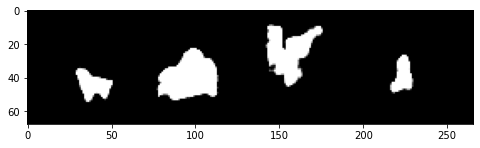

======================= DEPTHMAP ===================
actual: torch.Size([32, 1, 64, 64])


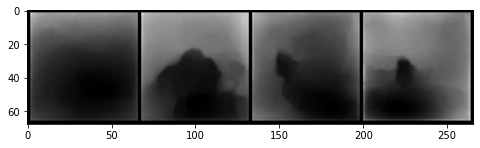

predicted: torch.Size([32, 1, 64, 64])


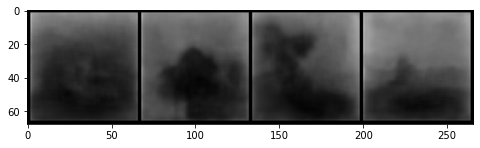

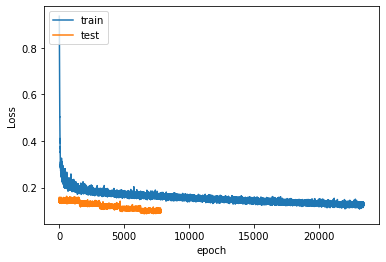

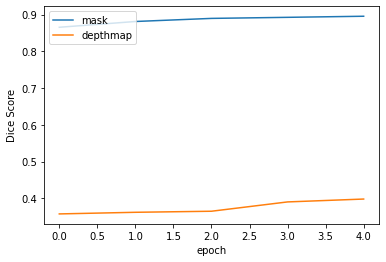

EPOCH: 6 LR: 0.001



*********************** TEST ***********************
Mask Dice Coeff:  0.896541409704522 Depthmap Dice Coeff:  0.4095862241830112
======================= IMAGE ======================
image: torch.Size([32, 3, 64, 64])


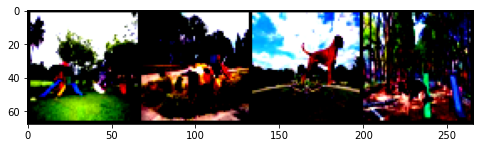

======================= MASK =======================
actual: torch.Size([32, 1, 64, 64])


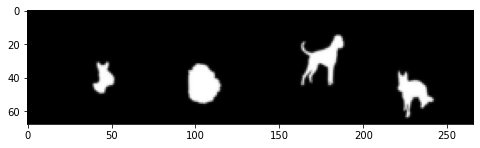

predicted: torch.Size([32, 1, 64, 64])


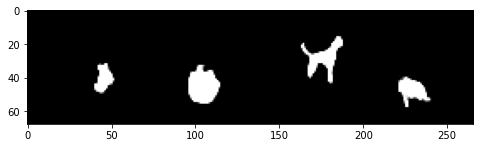

======================= DEPTHMAP ===================
actual: torch.Size([32, 1, 64, 64])


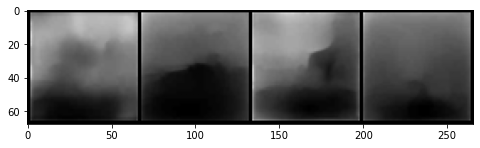

predicted: torch.Size([32, 1, 64, 64])


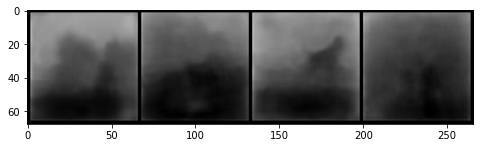

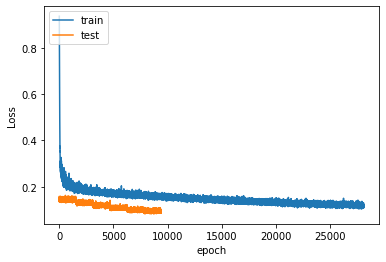

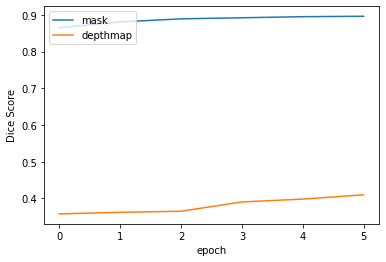

EPOCH: 7 LR: 0.001



*********************** TEST ***********************
Mask Dice Coeff:  0.8996469460079781 Depthmap Dice Coeff:  0.4047764528278197
======================= IMAGE ======================
image: torch.Size([32, 3, 64, 64])


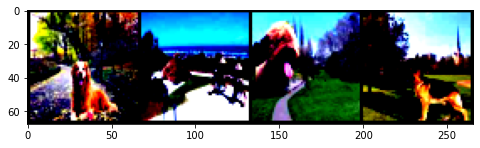

======================= MASK =======================
actual: torch.Size([32, 1, 64, 64])


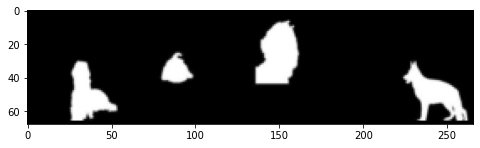

predicted: torch.Size([32, 1, 64, 64])


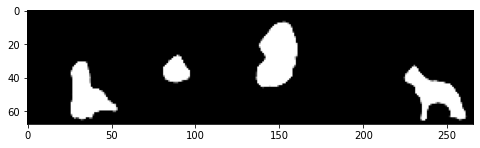

======================= DEPTHMAP ===================
actual: torch.Size([32, 1, 64, 64])


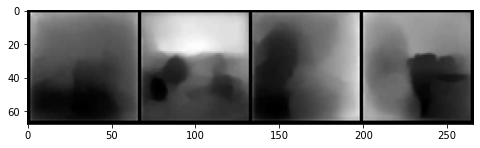

predicted: torch.Size([32, 1, 64, 64])


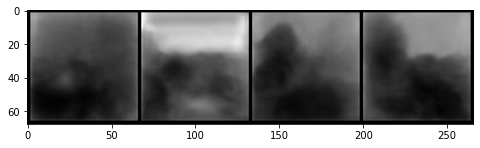

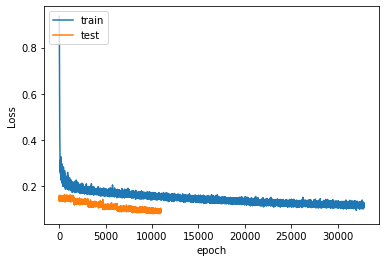

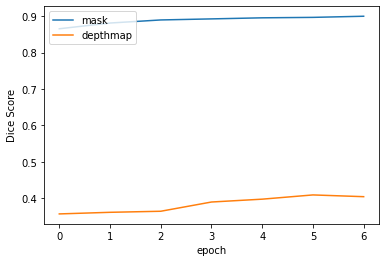

EPOCH: 8 LR: 0.001



*********************** TEST ***********************
Mask Dice Coeff:  0.900017919711249 Depthmap Dice Coeff:  0.40776494257890944
======================= IMAGE ======================
image: torch.Size([32, 3, 64, 64])


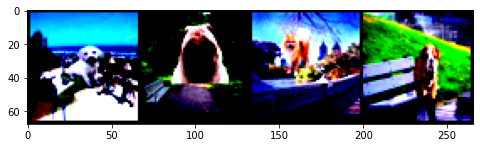

======================= MASK =======================
actual: torch.Size([32, 1, 64, 64])


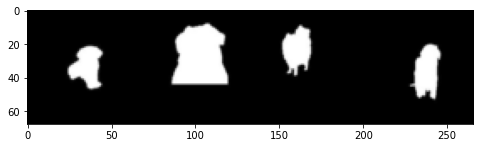

predicted: torch.Size([32, 1, 64, 64])


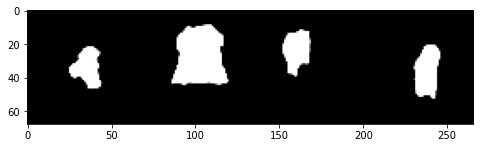

======================= DEPTHMAP ===================
actual: torch.Size([32, 1, 64, 64])


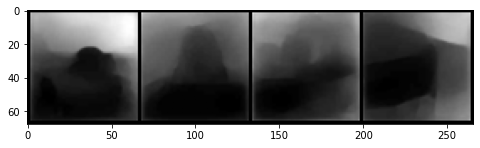

predicted: torch.Size([32, 1, 64, 64])


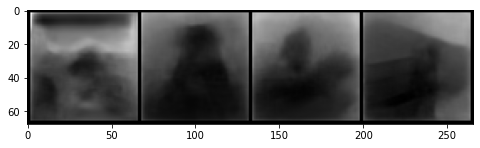

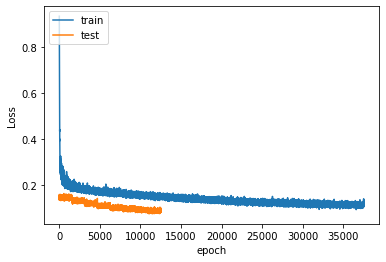

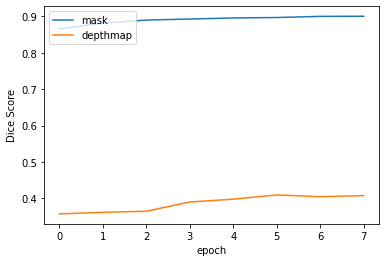

EPOCH: 9 LR: 0.001



*********************** TEST ***********************
Mask Dice Coeff:  0.9015452207393243 Depthmap Dice Coeff:  0.4184036202828852
======================= IMAGE ======================
image: torch.Size([32, 3, 64, 64])


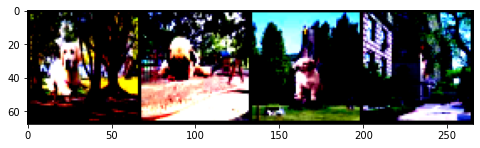

======================= MASK =======================
actual: torch.Size([32, 1, 64, 64])


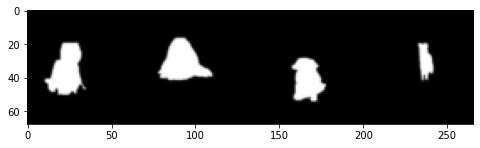

predicted: torch.Size([32, 1, 64, 64])


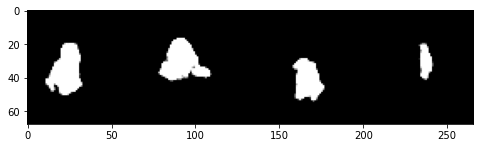

======================= DEPTHMAP ===================
actual: torch.Size([32, 1, 64, 64])


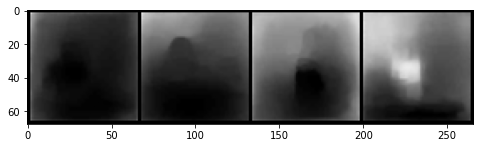

predicted: torch.Size([32, 1, 64, 64])


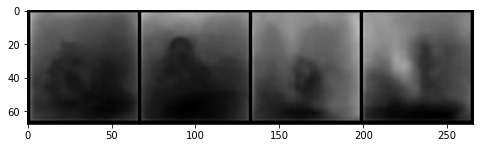

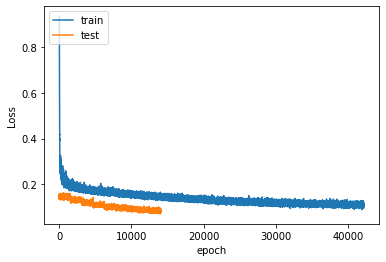

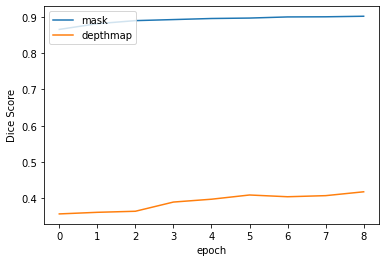

EPOCH: 10 LR: 0.001



*********************** TEST ***********************
Mask Dice Coeff:  0.9034353782561675 Depthmap Dice Coeff:  0.41105813878664055
======================= IMAGE ======================
image: torch.Size([32, 3, 64, 64])


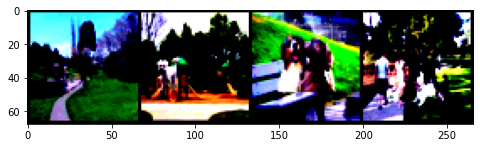

======================= MASK =======================
actual: torch.Size([32, 1, 64, 64])


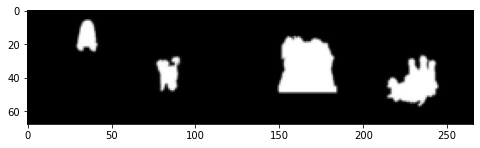

predicted: torch.Size([32, 1, 64, 64])


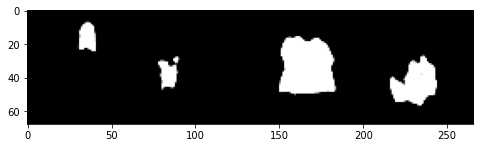

======================= DEPTHMAP ===================
actual: torch.Size([32, 1, 64, 64])


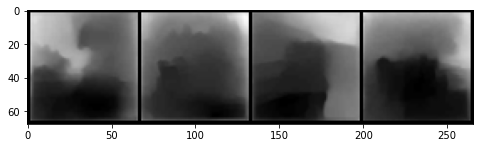

predicted: torch.Size([32, 1, 64, 64])


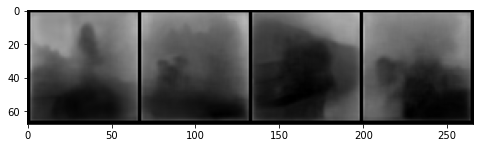

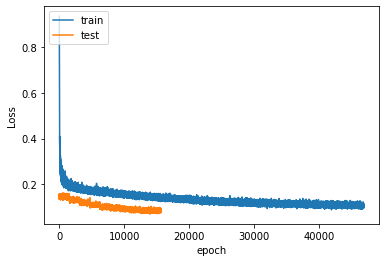

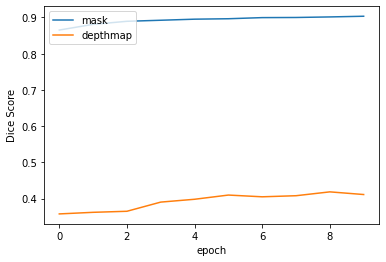

EPOCH: 11 LR: 0.001



*********************** TEST ***********************
Mask Dice Coeff:  0.9042682084454532 Depthmap Dice Coeff:  0.41632297436777627
======================= IMAGE ======================
image: torch.Size([32, 3, 64, 64])


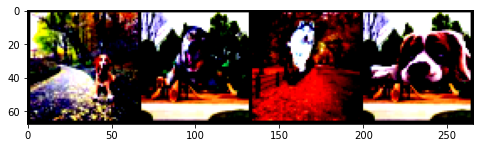

======================= MASK =======================
actual: torch.Size([32, 1, 64, 64])


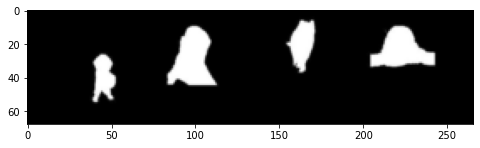

predicted: torch.Size([32, 1, 64, 64])


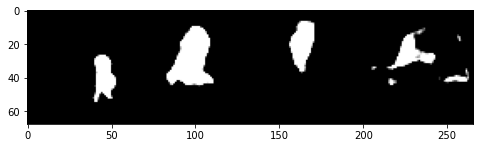

======================= DEPTHMAP ===================
actual: torch.Size([32, 1, 64, 64])


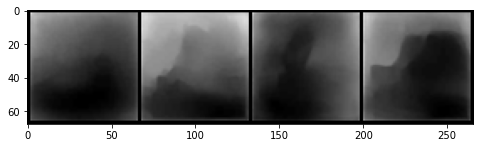

predicted: torch.Size([32, 1, 64, 64])


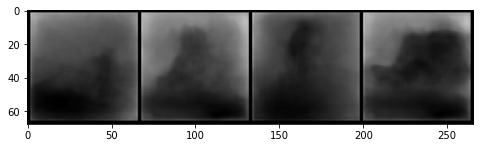

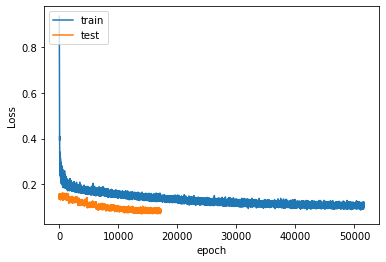

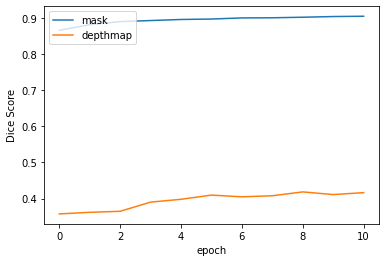

EPOCH: 12 LR: 0.001



*********************** TEST ***********************
Mask Dice Coeff:  0.9049649241255859 Depthmap Dice Coeff:  0.4172053404786384
======================= IMAGE ======================
image: torch.Size([32, 3, 64, 64])


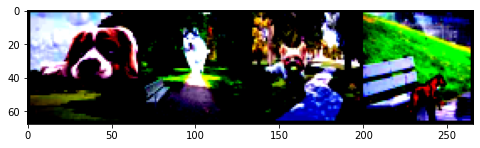

======================= MASK =======================
actual: torch.Size([32, 1, 64, 64])


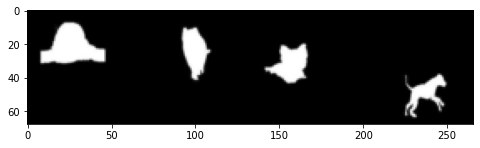

predicted: torch.Size([32, 1, 64, 64])


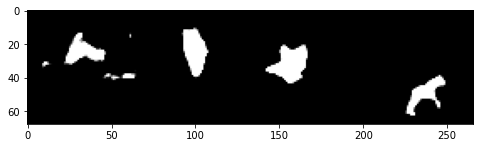

======================= DEPTHMAP ===================
actual: torch.Size([32, 1, 64, 64])


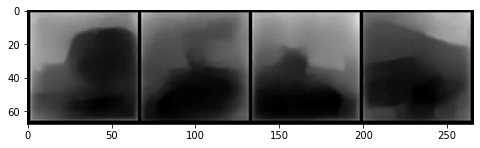

predicted: torch.Size([32, 1, 64, 64])


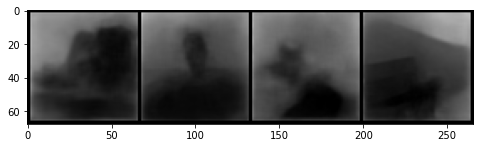

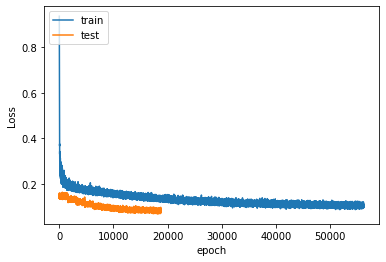

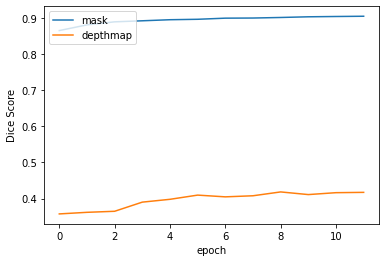

EPOCH: 13 LR: 0.001


In [0]:
status = Label('Starting Training the Model Now...')
display(status)
EPOCHS = 15
DEPTHWEIGHT = 0.7
PRINTINTERVAL = 1000
PRINTIMAGE = False
MODELSAVE = f'/content/gdrive/My Drive/Colab Notebooks/EVA4/S15-final/trainedmodels/trained_model'

train_losses = []
test_losses = []
dice_mask = []
dice_depth = []
dmask = 0
ddepth = 0

model = model.to(device)
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1,'LR:', optimizer.param_groups[0]['lr'])
    train_losses = training.train_model(status, 
                                        epoch, 
                                        model, 
                                        device, 
                                        trainloader, 
                                        criterion_mask, 
                                        criterion_depth, 
                                        optimizer, 
                                        depthweight=DEPTHWEIGHT, 
                                        printtestimg=PRINTIMAGE, 
                                        printinterval=PRINTINTERVAL, 
                                        scheduler=False)
    test_losses, dmask, ddepth  = training.test_model(model, device, criterion_mask, criterion_depth, testloader, DEPTHWEIGHT)
    dice_mask.append(dmask)
    dice_depth.append(ddepth)
    checkpoint = {
        'epoch': epoch + 1,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }
    torch.save(checkpoint, f'{MODELSAVE}_{epoch+1}.pth')
    visualize.plot_metric(train_losses, test_losses, "Loss", "train", "test")
    visualize.plot_metric(dice_mask, dice_depth, "Dice Score", "mask", "depthmap")

Continue Training..

Label(value='Starting Training the Model Now...')

EPOCH: 1 LR: 0.001



*********************** TEST ***********************
Mask Dice Coeff:  0.9061136171746086 Depthmap Dice Coeff:  0.4219070138339423
======================= IMAGE ======================
image: torch.Size([32, 3, 64, 64])


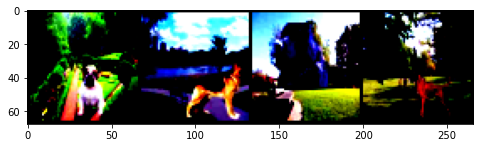

======================= MASK =======================
actual: torch.Size([32, 1, 64, 64])


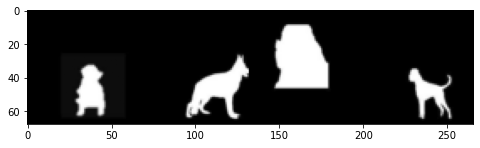

predicted: torch.Size([32, 1, 64, 64])


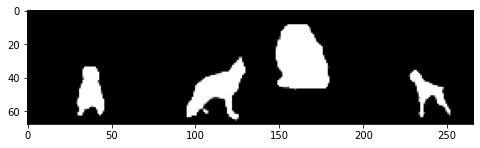

======================= DEPTHMAP ===================
actual: torch.Size([32, 1, 64, 64])


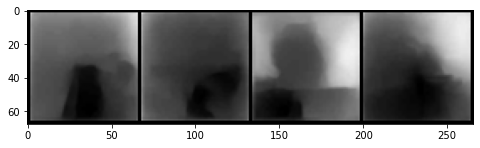

predicted: torch.Size([32, 1, 64, 64])


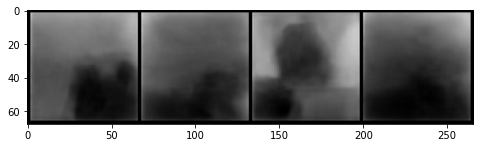

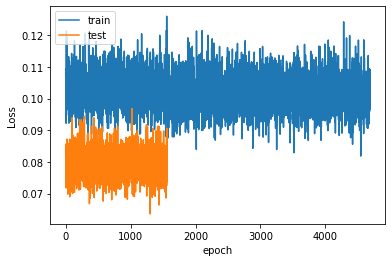

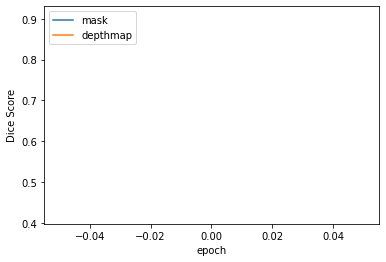

EPOCH: 2 LR: 0.001



*********************** TEST ***********************
Mask Dice Coeff:  0.9067135929527453 Depthmap Dice Coeff:  0.41804102448340186
======================= IMAGE ======================
image: torch.Size([32, 3, 64, 64])


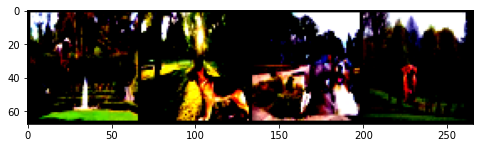

======================= MASK =======================
actual: torch.Size([32, 1, 64, 64])


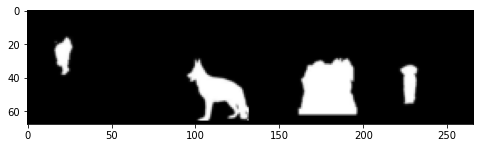

predicted: torch.Size([32, 1, 64, 64])


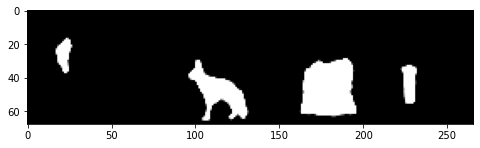

======================= DEPTHMAP ===================
actual: torch.Size([32, 1, 64, 64])


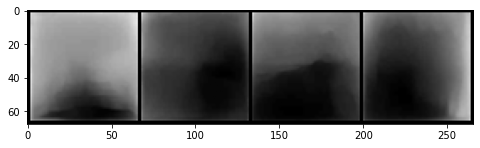

predicted: torch.Size([32, 1, 64, 64])


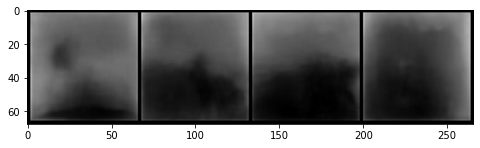

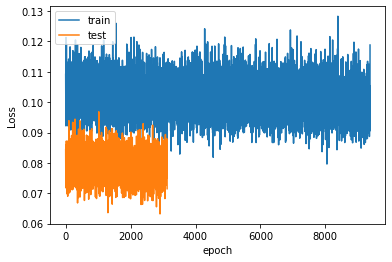

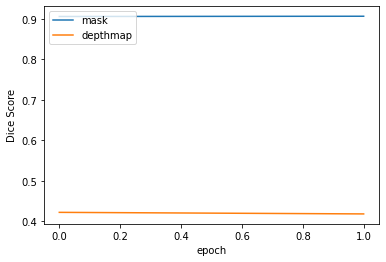

EPOCH: 3 LR: 0.001


Buffered data was truncated after reaching the output size limit.

In [0]:
status = Label('Starting Training the Model Now...')
display(status)
STARTEPOCH = 12
EPOCHS = 15
DEPTHWEIGHT = 0.7
PRINTINTERVAL = 1000
PRINTIMAGE = False
MODELSAVE = f'/content/gdrive/My Drive/Colab Notebooks/EVA4/S15-final/trainedmodels/trained_model'

train_losses = []
test_losses = []
dice_mask = []
dice_depth = []
dmask = 0
ddepth = 0

model = model.to(device)
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1,'LR:', optimizer.param_groups[0]['lr'])
    train_losses = training.train_model(status, 
                                        epoch, 
                                        model, 
                                        device, 
                                        trainloader, 
                                        criterion_mask, 
                                        criterion_depth, 
                                        optimizer, 
                                        depthweight=DEPTHWEIGHT, 
                                        printtestimg=PRINTIMAGE, 
                                        printinterval=PRINTINTERVAL, 
                                        scheduler=False)
    test_losses, dmask, ddepth  = training.test_model(model, device, criterion_mask, criterion_depth, testloader, DEPTHWEIGHT)
    dice_mask.append(dmask)
    dice_depth.append(ddepth)
    checkpoint = {
        'epoch': epoch + 1,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }
    torch.save(checkpoint, f'{MODELSAVE}_{STARTEPOCH+1}.pth')
    STARTEPOCH = STARTEPOCH + 1
    visualize.plot_metric(train_losses, test_losses, "Loss", "train", "test")
    visualize.plot_metric(dice_mask, dice_depth, "Dice Score", "mask", "depthmap")

Continue Training..

Label(value='Starting Training the Model Now...')

EPOCH: 1 LR: 0.001



*********************** TEST ***********************
Mask Dice Coeff:  0.9100930229334669 Depthmap Dice Coeff:  0.43518867419457025
======================= IMAGE ======================
image: torch.Size([32, 3, 64, 64])


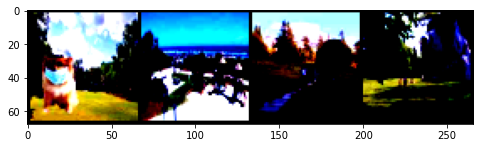

======================= MASK =======================
actual: torch.Size([32, 1, 64, 64])


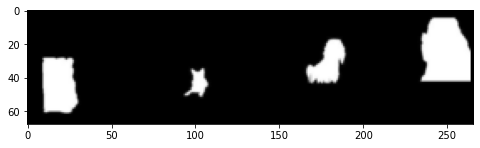

predicted: torch.Size([32, 1, 64, 64])


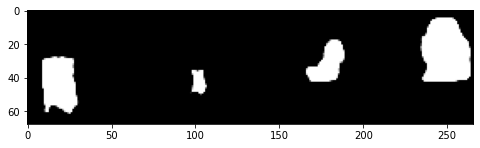

======================= DEPTHMAP ===================
actual: torch.Size([32, 1, 64, 64])


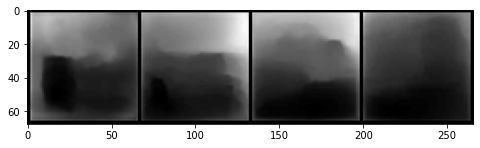

predicted: torch.Size([32, 1, 64, 64])


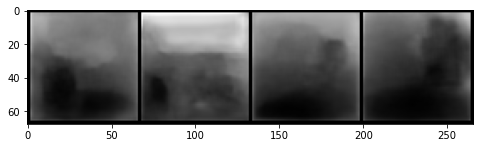

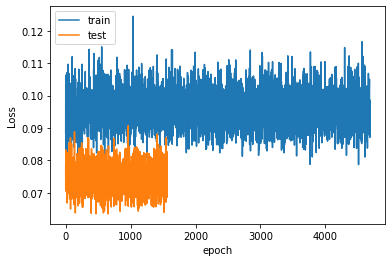

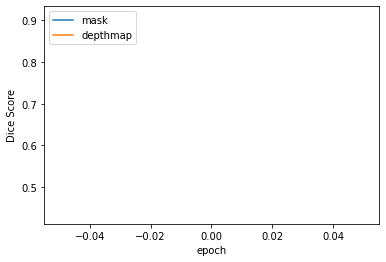

EPOCH: 2 LR: 0.001



*********************** TEST ***********************
Mask Dice Coeff:  0.9105126192687187 Depthmap Dice Coeff:  0.43259146243276614
======================= IMAGE ======================
image: torch.Size([32, 3, 64, 64])


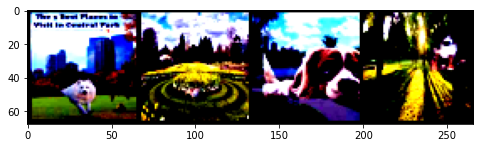

======================= MASK =======================
actual: torch.Size([32, 1, 64, 64])


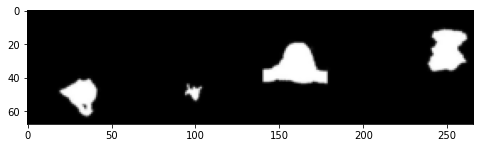

predicted: torch.Size([32, 1, 64, 64])


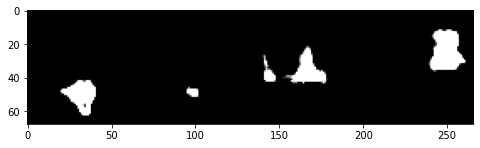

======================= DEPTHMAP ===================
actual: torch.Size([32, 1, 64, 64])


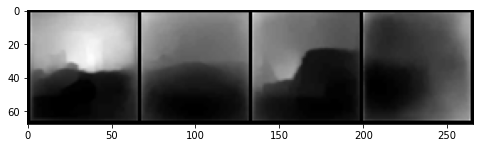

predicted: torch.Size([32, 1, 64, 64])


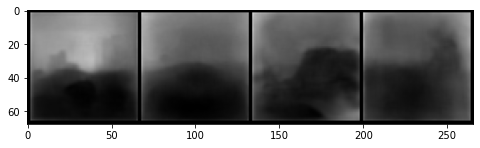

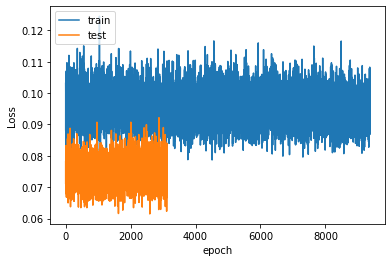

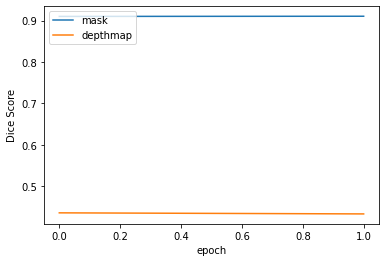

EPOCH: 3 LR: 0.001


In [0]:
status = Label('Starting Training the Model Now...')
display(status)
STARTEPOCH = 19
EPOCHS = 6
DEPTHWEIGHT = 0.7
PRINTINTERVAL = 1000
PRINTIMAGE = False
MODELSAVE = f'/content/gdrive/My Drive/Colab Notebooks/EVA4/S15-final/trainedmodels/trained_model'

train_losses = []
test_losses = []
dice_mask = []
dice_depth = []
dmask = 0
ddepth = 0

model = model.to(device)
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1,'LR:', optimizer.param_groups[0]['lr'])
    train_losses = training.train_model(status, 
                                        epoch, 
                                        model, 
                                        device, 
                                        trainloader, 
                                        criterion_mask, 
                                        criterion_depth, 
                                        optimizer, 
                                        depthweight=DEPTHWEIGHT, 
                                        printtestimg=PRINTIMAGE, 
                                        printinterval=PRINTINTERVAL, 
                                        scheduler=False)
    test_losses, dmask, ddepth  = training.test_model(model, device, criterion_mask, criterion_depth, testloader, DEPTHWEIGHT)
    dice_mask.append(dmask)
    dice_depth.append(ddepth)
    checkpoint = {
        'epoch': epoch + 1,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }
    torch.save(checkpoint, f'{MODELSAVE}_{STARTEPOCH+1}.pth')
    STARTEPOCH = STARTEPOCH + 1
    visualize.plot_metric(train_losses, test_losses, "Loss", "train", "test")
    visualize.plot_metric(dice_mask, dice_depth, "Dice Score", "mask", "depthmap")

Label(value='Starting Training the Model Now...')

EPOCH: 1 LR: 0.001



*********************** TEST ***********************
Mask Dice Coeff:  0.9107245242298221 Depthmap Dice Coeff:  0.4301420548407603
======================= IMAGE ======================
image: torch.Size([32, 3, 64, 64])


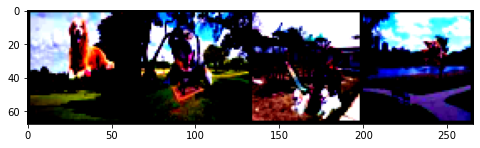

======================= MASK =======================
actual: torch.Size([32, 1, 64, 64])


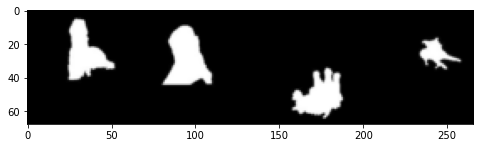

predicted: torch.Size([32, 1, 64, 64])


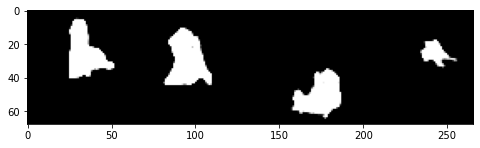

======================= DEPTHMAP ===================
actual: torch.Size([32, 1, 64, 64])


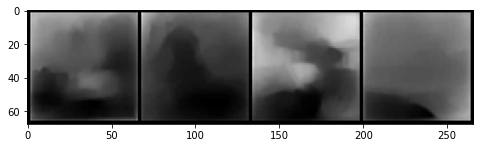

predicted: torch.Size([32, 1, 64, 64])


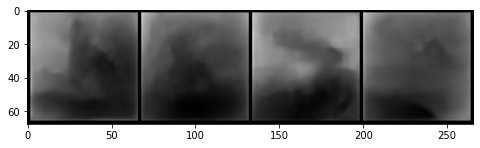

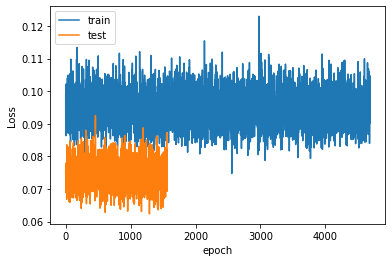

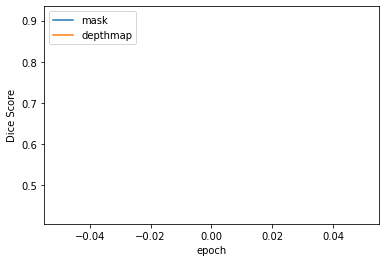

EPOCH: 2 LR: 0.001



*********************** TEST ***********************
Mask Dice Coeff:  0.9109922820989398 Depthmap Dice Coeff:  0.42290834890903756
======================= IMAGE ======================
image: torch.Size([32, 3, 64, 64])


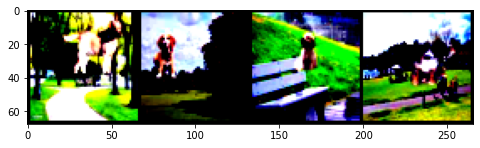

======================= MASK =======================
actual: torch.Size([32, 1, 64, 64])


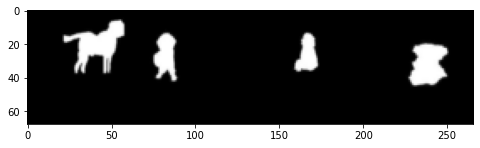

predicted: torch.Size([32, 1, 64, 64])


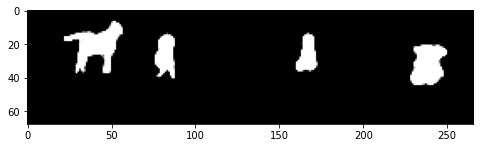

======================= DEPTHMAP ===================
actual: torch.Size([32, 1, 64, 64])


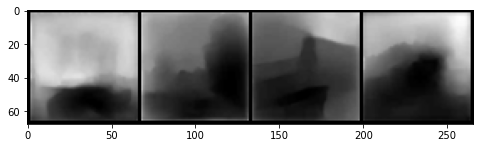

predicted: torch.Size([32, 1, 64, 64])


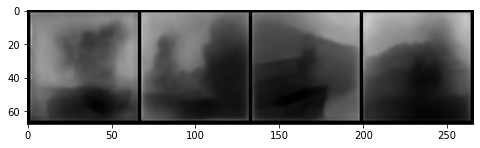

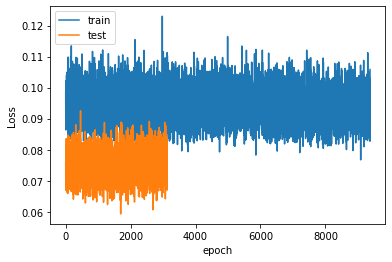

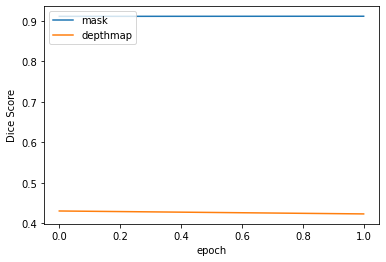

EPOCH: 3 LR: 0.001


In [0]:
status = Label('Starting Training the Model Now...')
display(status)
STARTEPOCH = 21
EPOCHS = 4
DEPTHWEIGHT = 0.7
PRINTINTERVAL = 1000
PRINTIMAGE = False
MODELSAVE = f'/content/gdrive/My Drive/Colab Notebooks/EVA4/S15-final/trainedmodels/trained_model'

train_losses = []
test_losses = []
dice_mask = []
dice_depth = []
dmask = 0
ddepth = 0

model = model.to(device)
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1,'LR:', optimizer.param_groups[0]['lr'])
    train_losses = training.train_model(status, 
                                        epoch, 
                                        model, 
                                        device, 
                                        trainloader, 
                                        criterion_mask, 
                                        criterion_depth, 
                                        optimizer, 
                                        depthweight=DEPTHWEIGHT, 
                                        printtestimg=PRINTIMAGE, 
                                        printinterval=PRINTINTERVAL, 
                                        scheduler=False)
    test_losses, dmask, ddepth  = training.test_model(model, device, criterion_mask, criterion_depth, testloader, DEPTHWEIGHT)
    dice_mask.append(dmask)
    dice_depth.append(ddepth)
    checkpoint = {
        'epoch': epoch + 1,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }
    torch.save(checkpoint, f'{MODELSAVE}_{STARTEPOCH+1}.pth')
    STARTEPOCH = STARTEPOCH + 1
    visualize.plot_metric(train_losses, test_losses, "Loss", "train", "test")
    visualize.plot_metric(dice_mask, dice_depth, "Dice Score", "mask", "depthmap")

Train for 5 Epochs with LROnPlateau

Label(value='Starting Training the Model Now...')

EPOCH: 1 LR: 0.001


Epoch     8: reducing learning rate of group 0 to 1.0000e-04.
Epoch    13: reducing learning rate of group 0 to 1.0000e-05.




*********************** TEST ***********************
Mask Dice Coeff:  0.9109122724160885 Depthmap Dice Coeff:  0.4300077636502755
======================= IMAGE ======================
image: torch.Size([32, 3, 64, 64])


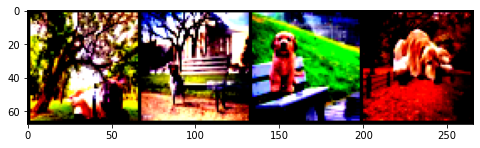

======================= MASK =======================
actual: torch.Size([32, 1, 64, 64])


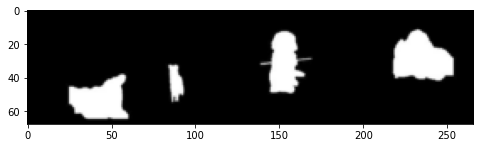

predicted: torch.Size([32, 1, 64, 64])


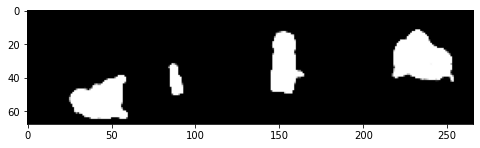

======================= DEPTHMAP ===================
actual: torch.Size([32, 1, 64, 64])


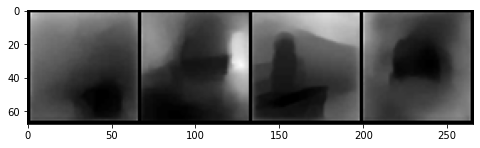

predicted: torch.Size([32, 1, 64, 64])


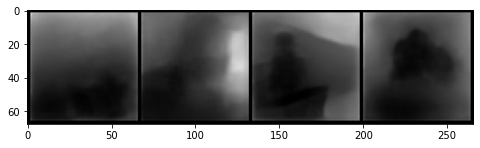

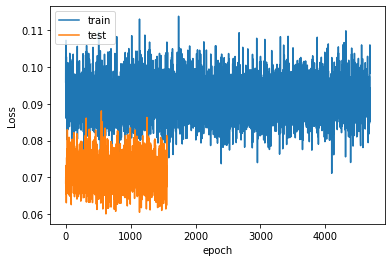

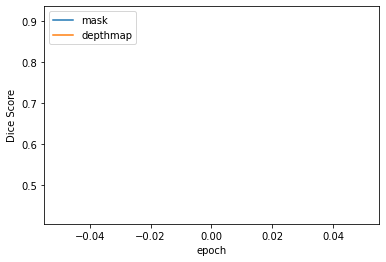

EPOCH: 2 LR: 1e-05



*********************** TEST ***********************
Mask Dice Coeff:  0.9113980376102645 Depthmap Dice Coeff:  0.4302524562951318
======================= IMAGE ======================
image: torch.Size([32, 3, 64, 64])


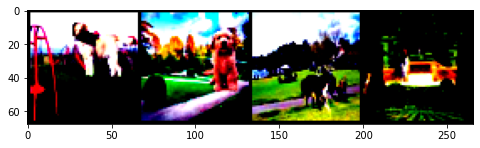

======================= MASK =======================
actual: torch.Size([32, 1, 64, 64])


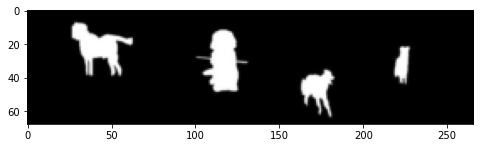

predicted: torch.Size([32, 1, 64, 64])


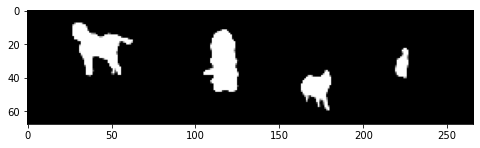

======================= DEPTHMAP ===================
actual: torch.Size([32, 1, 64, 64])


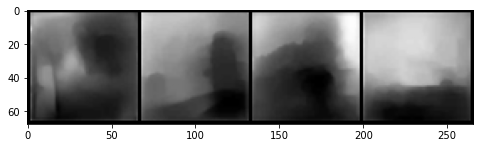

predicted: torch.Size([32, 1, 64, 64])


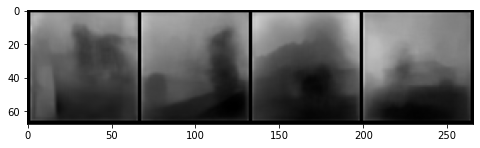

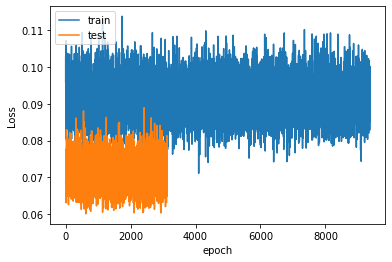

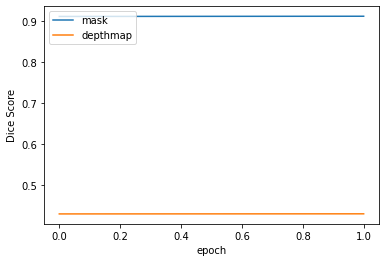

EPOCH: 3 LR: 1e-05



*********************** TEST ***********************
Mask Dice Coeff:  0.9112792303755889 Depthmap Dice Coeff:  0.42918569204216955
======================= IMAGE ======================
image: torch.Size([32, 3, 64, 64])


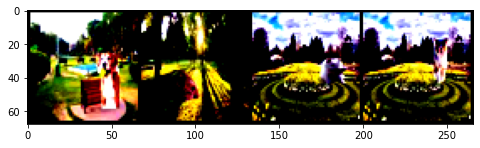

======================= MASK =======================
actual: torch.Size([32, 1, 64, 64])


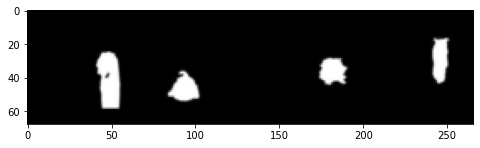

predicted: torch.Size([32, 1, 64, 64])


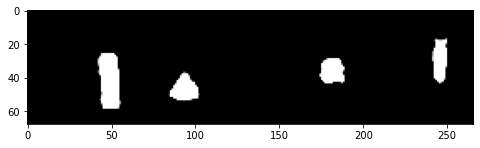

======================= DEPTHMAP ===================
actual: torch.Size([32, 1, 64, 64])


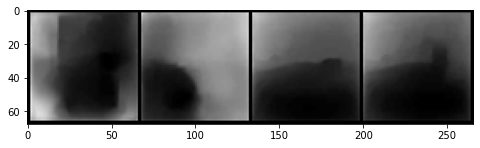

predicted: torch.Size([32, 1, 64, 64])


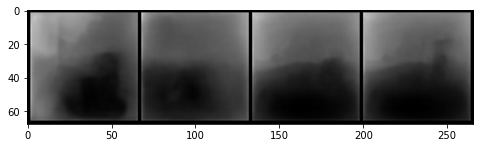

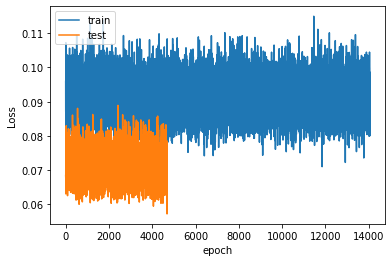

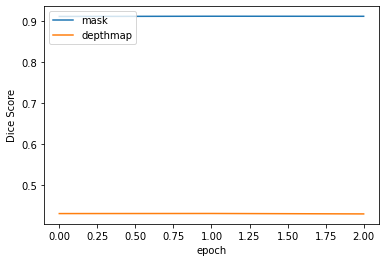

EPOCH: 4 LR: 1e-05



*********************** TEST ***********************
Mask Dice Coeff:  0.9110143091994375 Depthmap Dice Coeff:  0.4301028388170424
======================= IMAGE ======================
image: torch.Size([32, 3, 64, 64])


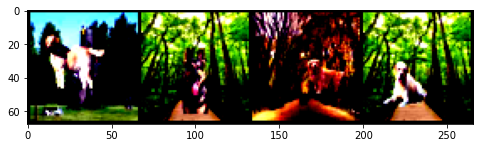

======================= MASK =======================
actual: torch.Size([32, 1, 64, 64])


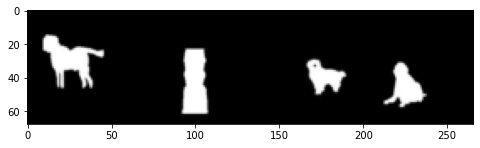

predicted: torch.Size([32, 1, 64, 64])


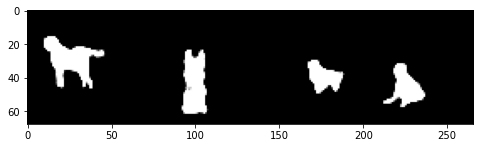

======================= DEPTHMAP ===================
actual: torch.Size([32, 1, 64, 64])


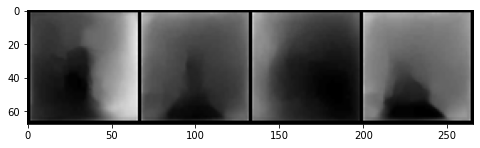

predicted: torch.Size([32, 1, 64, 64])


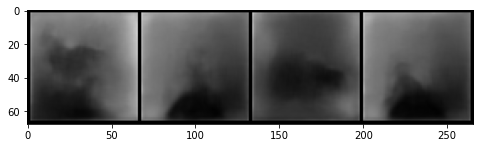

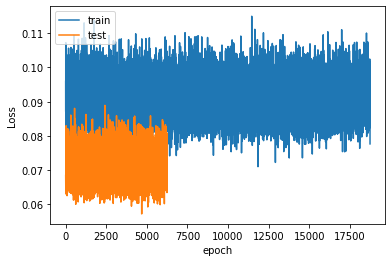

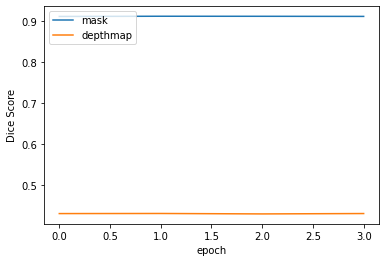

EPOCH: 5 LR: 1e-05



*********************** TEST ***********************
Mask Dice Coeff:  0.9110323244840459 Depthmap Dice Coeff:  0.4300402346057001
======================= IMAGE ======================
image: torch.Size([32, 3, 64, 64])


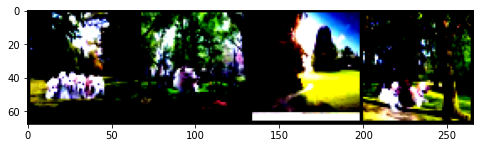

======================= MASK =======================
actual: torch.Size([32, 1, 64, 64])


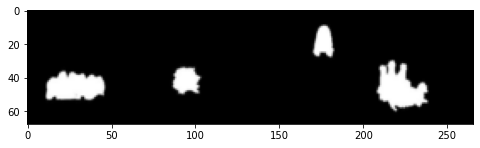

predicted: torch.Size([32, 1, 64, 64])


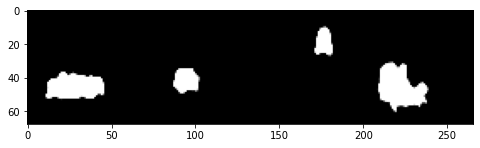

======================= DEPTHMAP ===================
actual: torch.Size([32, 1, 64, 64])


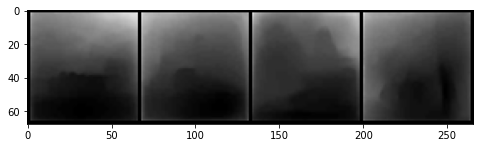

predicted: torch.Size([32, 1, 64, 64])


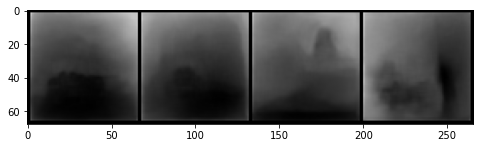

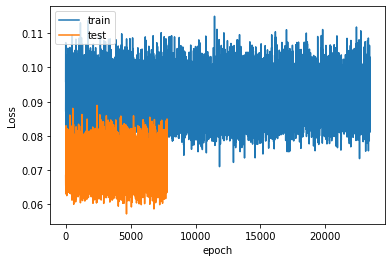

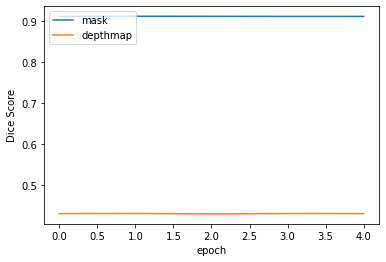

In [15]:
status = Label('Starting Training the Model Now...')
display(status)
STARTEPOCH = 23
EPOCHS = 5
DEPTHWEIGHT = 0.7
PRINTINTERVAL = 1000
PRINTIMAGE = False
MODELSAVE = f'/content/gdrive/My Drive/Colab Notebooks/EVA4/S15-final/trainedmodels/trained_model'

train_losses = []
test_losses = []
dice_mask = []
dice_depth = []
dmask = 0
ddepth = 0

model = model.to(device)
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1,'LR:', optimizer.param_groups[0]['lr'])
    train_losses = training.train_model(status, 
                                        epoch, 
                                        model, 
                                        device, 
                                        trainloader, 
                                        criterion_mask, 
                                        criterion_depth, 
                                        optimizer, 
                                        depthweight=DEPTHWEIGHT, 
                                        printtestimg=PRINTIMAGE, 
                                        printinterval=PRINTINTERVAL, 
                                        scheduler=scheduler)
    test_losses, dmask, ddepth  = training.test_model(model, device, criterion_mask, criterion_depth, testloader, DEPTHWEIGHT)
    dice_mask.append(dmask)
    dice_depth.append(ddepth)
    checkpoint = {
        'epoch': epoch + 1,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }
    torch.save(checkpoint, f'{MODELSAVE}_{STARTEPOCH+1}.pth')
    STARTEPOCH = STARTEPOCH + 1
    visualize.plot_metric(train_losses, test_losses, "Loss", "train", "test")
    visualize.plot_metric(dice_mask, dice_depth, "Dice Score", "mask", "depthmap")